# 对象图的构建
此notebook是[Zhou Shi-Wei](http://htwzxwj.github.io)学位论文开题报告的toy实验：
将会从一张分割图中按照分割区域分别提取深度特征以及边关系的空间特征，以此构成图结构。

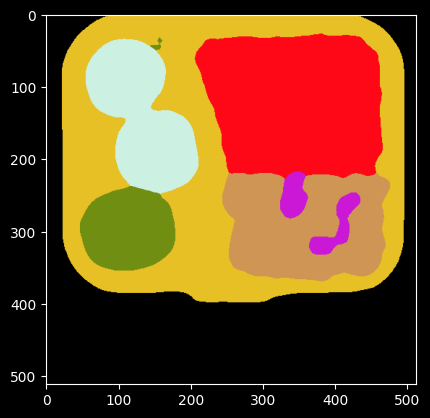

Tensor shape: torch.Size([3, 512, 512])
(512, 512)
Image mode: P
Image mode after conversion: RGB
RGB image shape: (512, 512, 3)
Number of channels in RGB image: 3


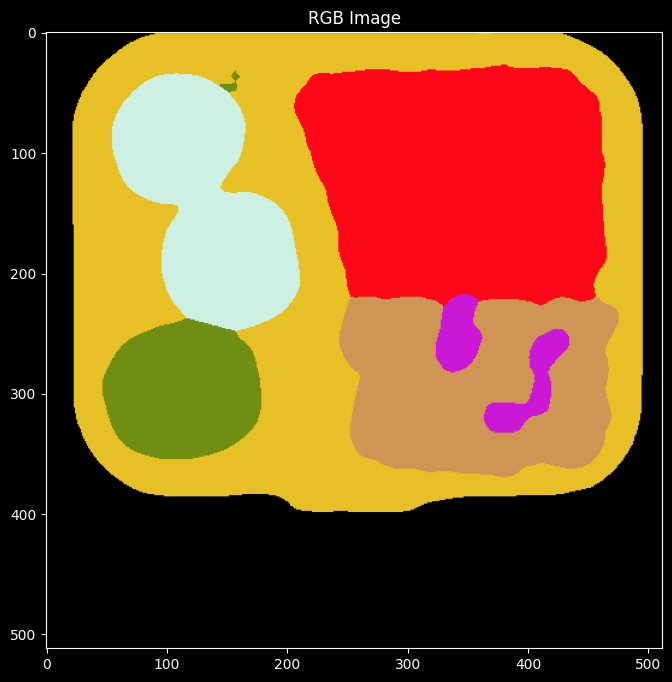

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

seg_mask_path = '/data/datasets/mvtec_loco/MVTec_LOCO_AD_seg_all/breakfast_box/train/good/000.png'
seg_mask = Image.open(seg_mask_path)
# Display the image
plt.imshow(seg_mask)
plt.show()

# 展示分割效果

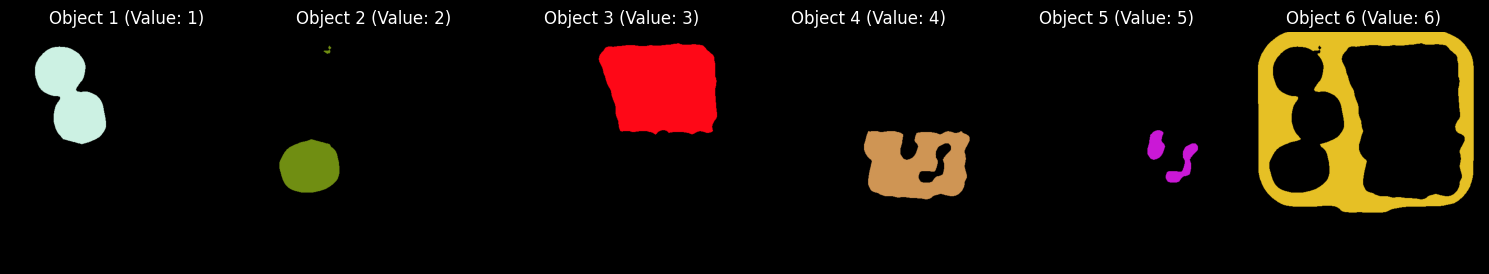

In [3]:
import numpy as np
seg_array = np.array(seg_mask)
#  读取不同颜色的图像
unique_values = np.unique(seg_array)
non_zero_values = unique_values[unique_values > 0]  # 将黑色排除
fig, axes = plt.subplots(nrows=1, ncols=len(non_zero_values), figsize=(15, 5))

# 迭代读取每一个非黑色区域
for i, value in enumerate(non_zero_values):
    # Create a mask where the current segment is preserved and everything else is set to 0
    mask = np.zeros_like(seg_array)
    mask[seg_array == value] = value
    
    # Create a PIL Image from the mask, using the same palette as the original image
    mask_img = Image.fromarray(mask, mode='P')
    mask_img.putpalette(seg_mask.getpalette())
    
    # Display the mask
    axes[i].imshow(mask_img)
    axes[i].set_title(f'Object {i+1} (Value: {value})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

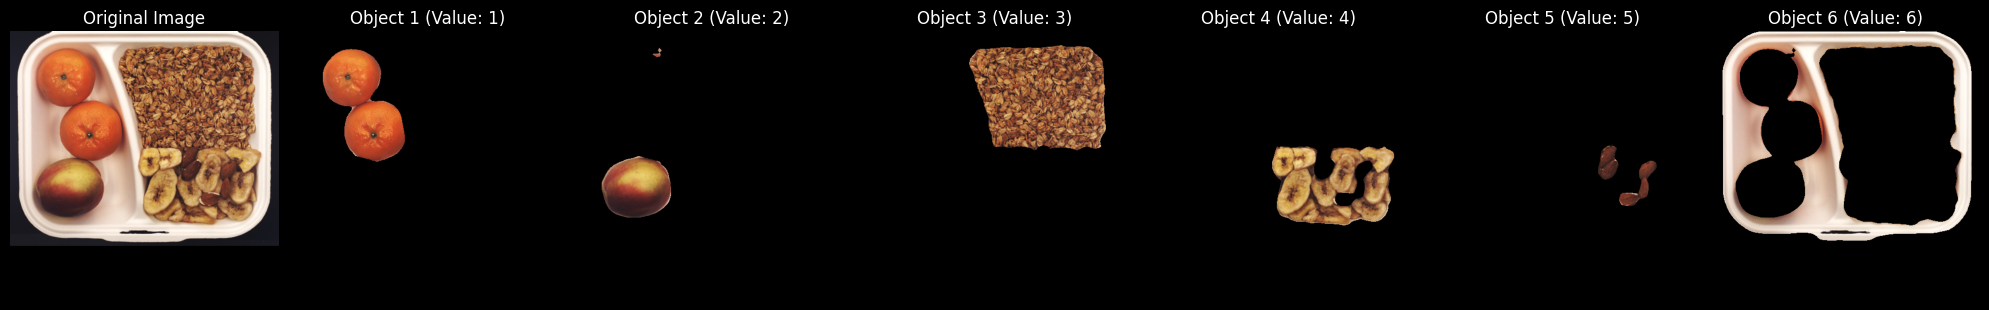

In [4]:
# 加载原始图像
orig_img_path = '/data/datasets/mvtec_loco/orig_512/breakfast_box/train/good/000.png'
orig_img = Image.open(orig_img_path)
orig_img_array = np.array(orig_img)

# Create a figure to display the original image and the masked regions
fig_overlay, axes_overlay = plt.subplots(1, len(non_zero_values)+1, figsize=(20, 6))

# Display the original image in the first subplot
axes_overlay[0].imshow(orig_img)
axes_overlay[0].set_title('Original Image')
axes_overlay[0].axis('off')

# Create overlays for each unique segmentation value
for i, value in enumerate(non_zero_values):
    # Create a mask for the current segment
    mask = np.zeros_like(seg_array, dtype=bool)
    mask[seg_array == value] = True
    
    # Create a copy of the original image
    overlay_img = orig_img_array.copy()
    
    # Add a colored overlay to highlight the masked region
    # Choose a different color for each segment
    color = plt.cm.rainbow(i/len(non_zero_values))[:3]  # RGB color from rainbow colormap
    
    # Only show the masked region, everything else is black
    overlay_img = np.zeros_like(orig_img_array)  # Create a black image
    overlay_img[mask] = orig_img_array[mask]  # Copy only the masked region from original
    
    # Display the overlay
    axes_overlay[i+1].imshow(overlay_img)
    axes_overlay[i+1].set_title(f'Object {i+1} (Value: {value})')
    axes_overlay[i+1].axis('off')

plt.tight_layout()
plt.show()

# 提取深度特征

In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*list(model.children())[:-1]) # * 移除模型的分类头得到最后一层的特征
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dictionary to store features for each object
object_features = {}

for i, value in enumerate(non_zero_values):
    # Create mask for current object
    mask = seg_array == value
    
    obj_img = orig_img_array.copy()
    obj_img[~mask] = [0, 0, 0]  # * 背景全黑
    
    # TODO 按照mask区域对每个对象进行裁剪，即把所有的mask区域裁剪出来

    obj_pil = Image.fromarray(obj_img)  # * 使用PIL转换图像
    # Preprocess the image
    input_tensor = preprocess(obj_pil)
    input_batch = input_tensor.unsqueeze(0).to(device)  # * 添加batch维度并移动到GPU
    with torch.no_grad():
        features = model(input_batch)
    
    # Reshape and convert to numpy
    features = features.squeeze().cpu().numpy() # * 去掉batch维度并移动到CPU
    
    # Store the features
    object_features[f"Object_{i+1}_Value_{value}"] = features
    
    print(f"Extracted features for Object {i+1} (Value: {value}), shape: {features.shape}")

Extracted features for Object 1 (Value: 1), shape: (2048,)
Extracted features for Object 2 (Value: 2), shape: (2048,)
Extracted features for Object 3 (Value: 3), shape: (2048,)
Extracted features for Object 4 (Value: 4), shape: (2048,)
Extracted features for Object 5 (Value: 5), shape: (2048,)
Extracted features for Object 6 (Value: 6), shape: (2048,)


# 提取空间特征（边关系）

In [6]:

# * 计算空间关系
spatial_relations = {}
for i, value_i in enumerate(non_zero_values):
    mask_i = seg_array == value_i
    y_i, x_i = np.where(mask_i)
    center_i = (np.mean(y_i), np.mean(x_i))
    
    for j, value_j in enumerate(non_zero_values):
        if i != j:
            mask_j = seg_array == value_j
            y_j, x_j = np.where(mask_j)
            center_j = (np.mean(y_j), np.mean(x_j))
            
            distance = np.sqrt((center_i[0] - center_j[0])**2 + (center_i[1] - center_j[1])**2)
            direction = (center_j[0] - center_i[0], center_j[1] - center_i[1])
            spatial_relations[f"Object_{i+1}_to_Object_{j+1}"] = {
                "distance": distance,
                "direction": direction
            }
            # # Print the spatial relationships for each pair
            # print(f"Object_{i+1} to Object_{j+1}:")
            # print(f"  - Distance: {distance:.2f} pixels")
            # print(f"  - Direction vector: {direction}")
            # print()

print("Feature extraction and spatial relationship computation complete!")

Feature extraction and spatial relationship computation complete!


# 构建Graph结构

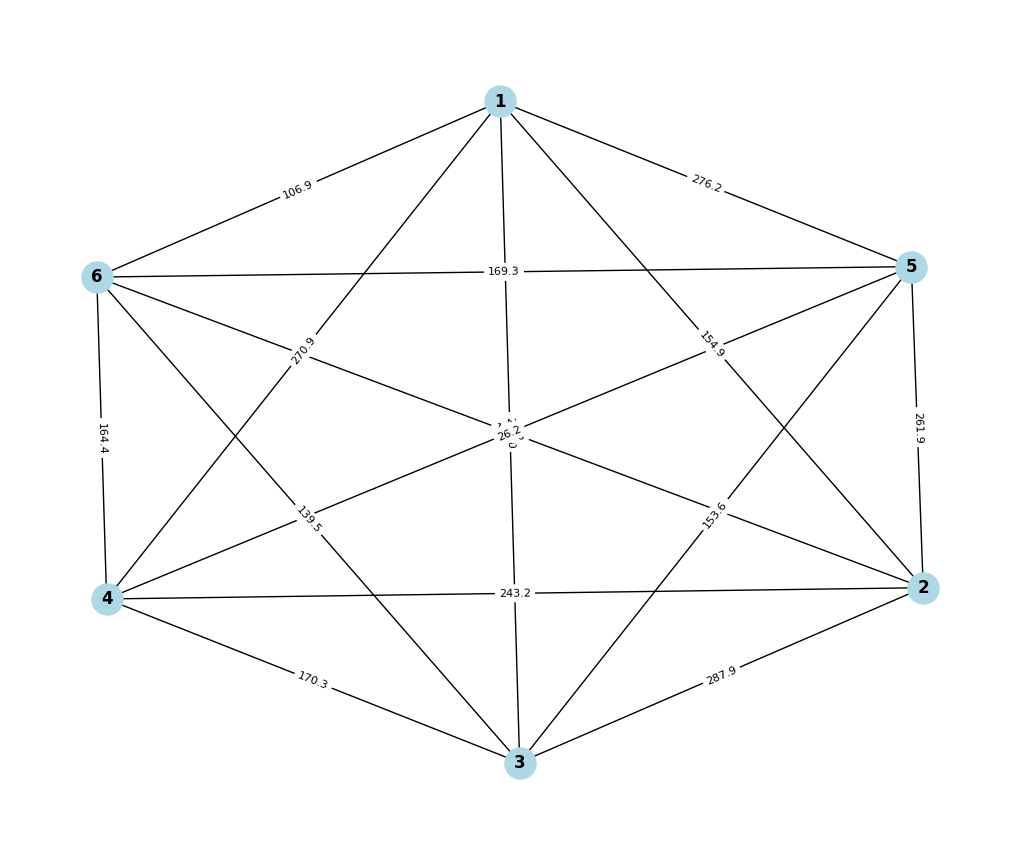

Graph created with 6 nodes and 15 edges
PyTorch Geometric Data: Data(x=[6, 2048], edge_index=[2, 30], edge_attr=[30, 3])


In [7]:
import networkx as nx
from torch_geometric.data import Data

# Create a networkx graph
G = nx.Graph()

# Add nodes with features
for i, value in enumerate(non_zero_values):
    node_id = i + 1  # Node IDs: 1, 2, 3, 4, 5, 6
    feature_key = f"Object_{node_id}_Value_{value}"
    G.add_node(node_id, features=object_features[feature_key], value=int(value))

# Add edges with attributes (fully connected graph)
for i in range(1, len(non_zero_values) + 1):
    for j in range(i+1, len(non_zero_values) + 1):  # Start from i+1 to avoid duplicate edges
        relation_key = f"Object_{i}_to_Object_{j}"
        distance = spatial_relations[relation_key]["distance"]
        direction = spatial_relations[relation_key]["direction"]
        G.add_edge(i, j, distance=float(distance), direction=direction)

# Convert to PyTorch Geometric format for deep learning
node_features = []
for i in range(1, len(non_zero_values) + 1):
    feature_key = f"Object_{i}_Value_{non_zero_values[i-1]}"
    node_features.append(object_features[feature_key])

# Stack node features
x = torch.tensor(np.stack(node_features), dtype=torch.float)

# Create edge indices and attributes
edge_index = []
edge_attr = []
for i in range(1, len(non_zero_values) + 1):
    for j in range(1, len(non_zero_values) + 1):
        if i != j:
            edge_index.append([i-1, j-1])  # 0-based indexing
            relation_key = f"Object_{i}_to_Object_{j}"
            distance = spatial_relations[relation_key]["distance"]
            direction_x, direction_y = spatial_relations[relation_key]["direction"]
            edge_attr.append([float(distance), float(direction_x), float(direction_y)])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # 2xE format
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# Create PyG data object
graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_weight='bold')
edge_labels = {(i, j): f"{G.edges[i, j]['distance']:.1f}" for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Object Graph with Spatial Relations")
plt.show()

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"PyTorch Geometric Data: {graph_data}")

In [8]:
import torch
from torch_geometric.nn import GATv2Conv, GCNConv

import torch.nn.functional as F

# Define a GNN model that supports edge attributes
class EdgeAttrGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim):
        super(EdgeAttrGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels, edge_dim=edge_dim)
        self.conv3 = GATv2Conv(hidden_channels, out_channels, edge_dim=edge_dim)
        
    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index, edge_attr=edge_attr)
        return x

# Initialize model parameters
in_channels = graph_data.x.size(1)  # 2048
hidden_channels = 64
out_channels = 16  # Can be adjusted based on your task
edge_dim = graph_data.edge_attr.size(1)  # 3 (distance, direction_x, direction_y)

# Create model and move to the same device as the data
model = EdgeAttrGNN(in_channels, hidden_channels, out_channels, edge_dim).to(device)

# Test forward pass
with torch.no_grad():
    output = model(graph_data.x.to(device), 
                   graph_data.edge_index.to(device), 
                   graph_data.edge_attr.to(device))

print(f"Input shape: {graph_data.x.shape}")
print(f"Edge index shape: {graph_data.edge_index.shape}")
print(f"Edge attributes shape: {graph_data.edge_attr.shape}")
print(f"Output shape: {output.shape}")
print("Forward pass successful!")

Input shape: torch.Size([6, 2048])
Edge index shape: torch.Size([2, 30])
Edge attributes shape: torch.Size([30, 3])
Output shape: torch.Size([6, 16])
Forward pass successful!
